In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.datasets import ImageFolder


c:\Users\KDP-25\.conda\envs\Torch_PY38\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 지정된 프로시저를 찾을 수 없습니다'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
class AnimalModule(nn.Module):
    def __init__(self, in_, out_):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_, out_channels=10, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.pool2 = nn.MaxPool2d(kernel_size=3)
        self.f1 = nn.Linear(7 * 7 * 20, 100)
        self.out_layer = nn.Linear(100, out_)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = x.view(-1, 7 * 7 * 20)
        x = F.relu(self.f1(x))
        x = self.out_layer(x)
        return x


In [3]:
def make_weights(labels, nclasses):
    labels = np.array(labels)
    weight_list = []

    for cls in range(nclasses):
        idx = np.where(labels == cls)[0]
        count = len(idx)
        weight = 1 / count
        weights = [weight] * count
        weight_list += weights

    return weight_list


In [4]:
preprocessing = transforms.Compose(
    [
        transforms.Resize((50, 50)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
    ]
)


In [5]:
train_root = "../../data/animals/train"
valid_root = "../../data/animals/val"
trainDS = ImageFolder(train_root, transform=preprocessing)
validDS = ImageFolder(valid_root, transform=preprocessing)


In [6]:
train_weights = make_weights(trainDS.targets, len(trainDS.classes))
train_weights = torch.DoubleTensor(train_weights)
valid_weights = make_weights(validDS.targets, len(validDS.classes))
valid_weights = torch.DoubleTensor(valid_weights)


In [7]:
train_weights.shape, valid_weights.shape


(torch.Size([13474]), torch.Size([1497]))

In [8]:
train_sampler = WeightedRandomSampler(train_weights, len(train_weights))
valid_sampler = WeightedRandomSampler(valid_weights, len(valid_weights))


In [9]:
batch_size = 32
trainDL = DataLoader(
    trainDS, batch_size=batch_size, sampler=train_sampler, drop_last=True
)
validDL = DataLoader(
    validDS, batch_size=batch_size, sampler=valid_sampler, drop_last=True
)


In [10]:
for image, label in trainDL:
    print("image:", image.size(), "type:", image.type())
    print("label:", label.size(), "type:", label.type())
    break


image: torch.Size([32, 3, 50, 50]) type: torch.FloatTensor
label: torch.Size([32]) type: torch.LongTensor


In [11]:
for image, label in trainDL:
    print(label.bincount())
    break


tensor([ 9, 10,  5,  4,  4])


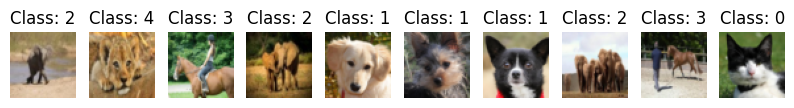

In [12]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis("off")
    plt.imshow(np.transpose(image[i], (1, 2, 0)))
    plt.title("Class: " + str(label[i].item()))


In [13]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

print("DEVICE :", DEVICE)


DEVICE : cpu


In [14]:
EPOCHS = 100
IN, OUT = 3, len(trainDS.classes)
MODEL = AnimalModule(IN, OUT).to(DEVICE)
OPTIMIZER = optim.Adam(MODEL.parameters())
LOSS_FN = nn.CrossEntropyLoss()

print(MODEL)


AnimalModule(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (f1): Linear(in_features=980, out_features=100, bias=True)
  (out_layer): Linear(in_features=100, out_features=5, bias=True)
)


In [15]:
from tqdm import tqdm


def learning(epochs, epoch, model, loader, optimizer, mode="train"):

    if mode == "train":
        model.train()

        is_train = True

    elif mode == "test":

        model.eval()

        is_train = False

    else:

        raise ValueError("Invalid mode:", mode)


    loss_value = 0

    correct = 0
    running_loss = 0.0

    with torch.set_grad_enabled(is_train):
        pbar = tqdm(enumerate(loader), total=len(loader))

        for batch_idx, (image, label) in pbar:

            image = image.to(DEVICE)
            label = label.to(DEVICE)

            output = model(image)

            loss = LOSS_FN(output, label)

            loss_value += loss.item()
            running_loss += loss.item()

            prediction = output.max(1, keepdim=True)[1]

            correct += prediction.eq(label.view_as(prediction)).sum().item()


            if is_train:

                optimizer.zero_grad()

                loss.backward()

                optimizer.step()
                if batch_idx % 10 == 9:
                    pbar.set_description(
                        f"Epoch [{epoch + 1}/{epochs}], 횟수 [{batch_idx + 1}/{len(loader)}], Loss: {running_loss/10:.4f}"
                    )
                    running_loss = 0.0


    loss_value /= len(loader.dataset)

    accuracy = 100.0 * correct / len(loader.dataset)

    return loss_value, accuracy


In [16]:
pre_test_loss = 100
pre_test_acc = 0
count = 0

for epoch in range(0, EPOCHS):
    learning(EPOCHS, epoch, MODEL, trainDL, OPTIMIZER, mode="train")
    test_loss, test_accuracy = learning(
        EPOCHS, epoch, MODEL, validDL, OPTIMIZER, mode="test"
    )
    print(
        f"\n[EPOCH: {epoch}], \tTest Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} % \n"
    )

    if pre_test_acc < test_accuracy:
        pre_test_acc = test_accuracy
        torch.save(MODEL, "animal_model.pth")

    if pre_test_loss > test_loss:
        pre_test_loss = test_loss
        count = 0
    else:
        count += 1
        if count == 10:
            break


100%|██████████| 46/46 [00:03<00:00, 15.13it/s]



[EPOCH: 0], 	Test Loss: 0.0308, 	Test Accuracy: 60.39 % 



100%|██████████| 46/46 [00:03<00:00, 14.25it/s]



[EPOCH: 1], 	Test Loss: 0.0218, 	Test Accuracy: 70.74 % 



100%|██████████| 46/46 [00:03<00:00, 11.52it/s]



[EPOCH: 2], 	Test Loss: 0.0186, 	Test Accuracy: 75.22 % 



100%|██████████| 46/46 [00:03<00:00, 13.68it/s]



[EPOCH: 3], 	Test Loss: 0.0195, 	Test Accuracy: 73.55 % 



100%|██████████| 46/46 [00:03<00:00, 13.16it/s]



[EPOCH: 4], 	Test Loss: 0.0188, 	Test Accuracy: 74.55 % 



100%|██████████| 46/46 [00:03<00:00, 13.36it/s]



[EPOCH: 5], 	Test Loss: 0.0187, 	Test Accuracy: 75.15 % 



100%|██████████| 46/46 [00:03<00:00, 11.85it/s]



[EPOCH: 6], 	Test Loss: 0.0174, 	Test Accuracy: 76.35 % 



100%|██████████| 46/46 [00:03<00:00, 13.47it/s]



[EPOCH: 7], 	Test Loss: 0.0165, 	Test Accuracy: 77.56 % 



100%|██████████| 46/46 [00:03<00:00, 14.52it/s]



[EPOCH: 8], 	Test Loss: 0.0174, 	Test Accuracy: 76.22 % 



100%|██████████| 46/46 [00:03<00:00, 13.94it/s]



[EPOCH: 9], 	Test Loss: 0.0163, 	Test Accuracy: 77.76 % 



100%|██████████| 46/46 [00:04<00:00, 10.70it/s]



[EPOCH: 10], 	Test Loss: 0.0156, 	Test Accuracy: 79.23 % 



100%|██████████| 46/46 [00:03<00:00, 13.26it/s]



[EPOCH: 11], 	Test Loss: 0.0176, 	Test Accuracy: 78.36 % 



100%|██████████| 46/46 [00:03<00:00, 14.22it/s]



[EPOCH: 12], 	Test Loss: 0.0158, 	Test Accuracy: 78.02 % 



100%|██████████| 46/46 [00:03<00:00, 13.61it/s]



[EPOCH: 13], 	Test Loss: 0.0181, 	Test Accuracy: 78.02 % 



100%|██████████| 46/46 [00:03<00:00, 11.80it/s]



[EPOCH: 14], 	Test Loss: 0.0172, 	Test Accuracy: 77.42 % 



100%|██████████| 46/46 [00:03<00:00, 12.73it/s]



[EPOCH: 15], 	Test Loss: 0.0162, 	Test Accuracy: 79.63 % 



100%|██████████| 46/46 [00:03<00:00, 13.98it/s]



[EPOCH: 16], 	Test Loss: 0.0150, 	Test Accuracy: 81.03 % 



100%|██████████| 46/46 [00:03<00:00, 13.70it/s]



[EPOCH: 17], 	Test Loss: 0.0159, 	Test Accuracy: 79.23 % 



100%|██████████| 46/46 [00:04<00:00, 11.49it/s]



[EPOCH: 18], 	Test Loss: 0.0171, 	Test Accuracy: 79.29 % 



100%|██████████| 46/46 [00:04<00:00, 10.37it/s]



[EPOCH: 19], 	Test Loss: 0.0163, 	Test Accuracy: 81.63 % 



100%|██████████| 46/46 [00:02<00:00, 15.36it/s]



[EPOCH: 20], 	Test Loss: 0.0175, 	Test Accuracy: 79.16 % 



100%|██████████| 46/46 [00:03<00:00, 13.98it/s]



[EPOCH: 21], 	Test Loss: 0.0170, 	Test Accuracy: 79.69 % 



100%|██████████| 46/46 [00:03<00:00, 12.97it/s]



[EPOCH: 22], 	Test Loss: 0.0165, 	Test Accuracy: 79.89 % 



100%|██████████| 46/46 [00:04<00:00, 11.04it/s]



[EPOCH: 23], 	Test Loss: 0.0166, 	Test Accuracy: 80.56 % 



100%|██████████| 46/46 [00:03<00:00, 13.93it/s]



[EPOCH: 24], 	Test Loss: 0.0172, 	Test Accuracy: 79.29 % 



100%|██████████| 46/46 [00:03<00:00, 13.94it/s]



[EPOCH: 25], 	Test Loss: 0.0201, 	Test Accuracy: 78.96 % 



100%|██████████| 46/46 [00:03<00:00, 12.44it/s]


[EPOCH: 26], 	Test Loss: 0.0202, 	Test Accuracy: 78.22 % 

